In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import seaborn as sns 

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
weather_df = pd.read_csv('delhi_temperature.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,temperature
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


In [3]:
weather_df.dtypes

temperature    float64
dtype: object

In [4]:
weather_df.index.dtype
#<M8[ns] is a specific dtype of datetime

dtype('<M8[ns]')

In [5]:
#weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

In [6]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    percent = percent*100
    #no need to plot missing data count, just print it
    #missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    #missing_data = missing_data[missing_data.Total > 0]    
    #missing_data.plot.bar(subplots=True, figsize=(16,9))
    
    print('Count of missing data : \n',total)
    print('% of missing data : \n',percent)

list_and_visualize_missing_data(weather_df)

Count of missing data : 
 temperature    673
dtype: int64
% of missing data : 
 temperature    0.666403
dtype: float64


In [7]:
#Fill missing data with forward fill
weather_df.ffill(inplace=True)
print('Count of missing data : ',weather_df[weather_df.isnull()].count())

Count of missing data :  temperature    0
dtype: int64


In [8]:
weather_df.describe()

,temperature
count,100990.000000
mean,25.438222
std,8.487994
min,1.000000
25%,19.000000
50%,27.000000
75%,32.000000
max,90.000000


In [9]:
#since max temperature 90 is unrealistic, we treat them as outliers and thus remove them
weather_df = weather_df[weather_df.temperature < 50]
weather_df.describe()

,temperature
count,100986.000000
mean,25.436387
std,8.482862
min,1.000000
25%,19.000000
50%,27.000000
75%,32.000000
max,47.000000


In [10]:
weather_df.head()

,temperature
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb28b6b1190>],
      dtype=object)

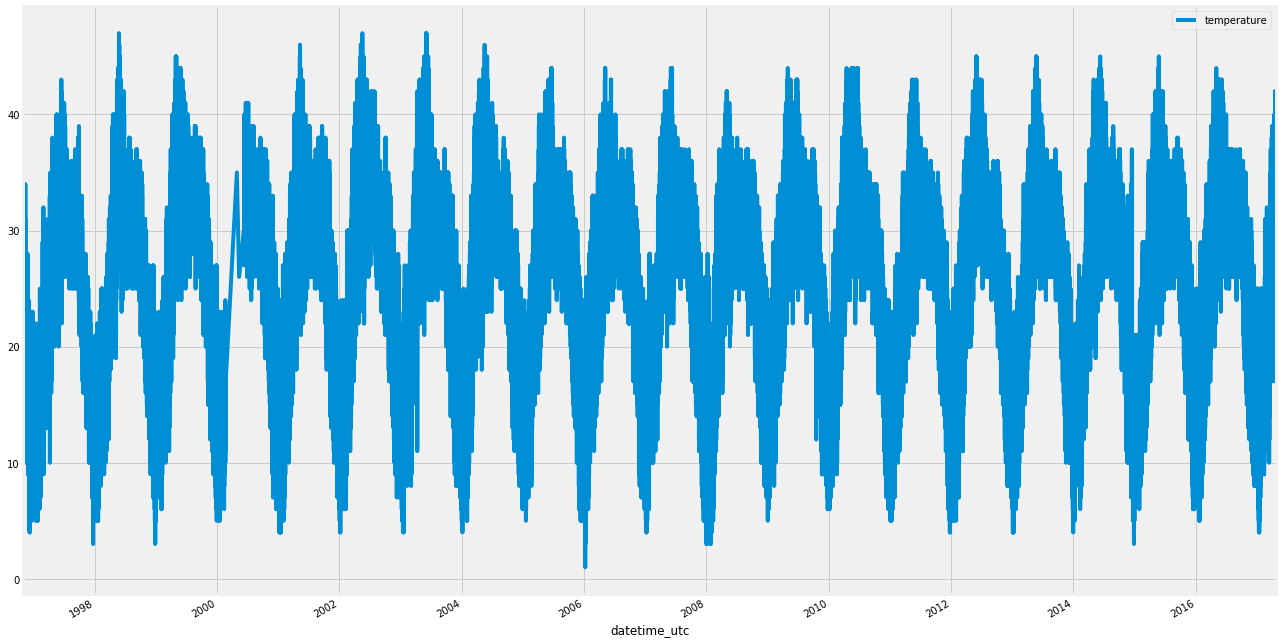

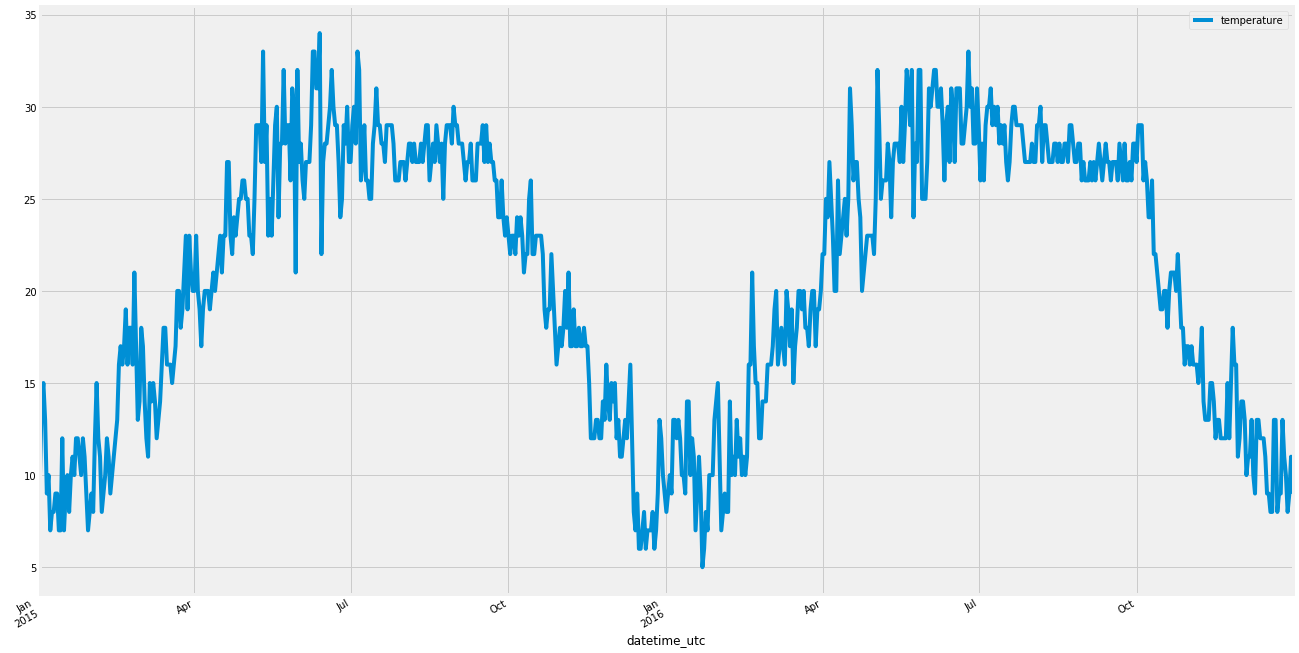

In [11]:
#check trend and seasonality of weather data
weather_df.plot(subplots=True, figsize=(20,12))
#detailed view of 2015 year
weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

In [12]:
#split dataset into training and testing data
train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')

In [13]:
train_df.head()

,temperature
datetime_utc,
2000-01-31,13.707670
2000-02-29,14.918977
2000-03-31,14.918977
2000-04-30,35.000000
2000-05-31,26.000000


In [14]:
train_df.describe()

,temperature
count,192.000000
mean,25.163693
std,7.036814
min,11.788321
25%,18.794601
50%,27.737850
75%,30.926985
max,36.183962


In [15]:
test_df.head()

,temperature
datetime_utc,
2016-01-31,15.007752
2016-02-29,19.468193
2016-03-31,25.696391
2016-04-30,32.546841
2016-05-31,34.777344


In [16]:
test_df.describe()

,temperature
count,16.000000
mean,25.884028
std,6.927166
min,15.007752
25%,19.204661
50%,27.335773
75%,31.140827
max,34.949561


In [17]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

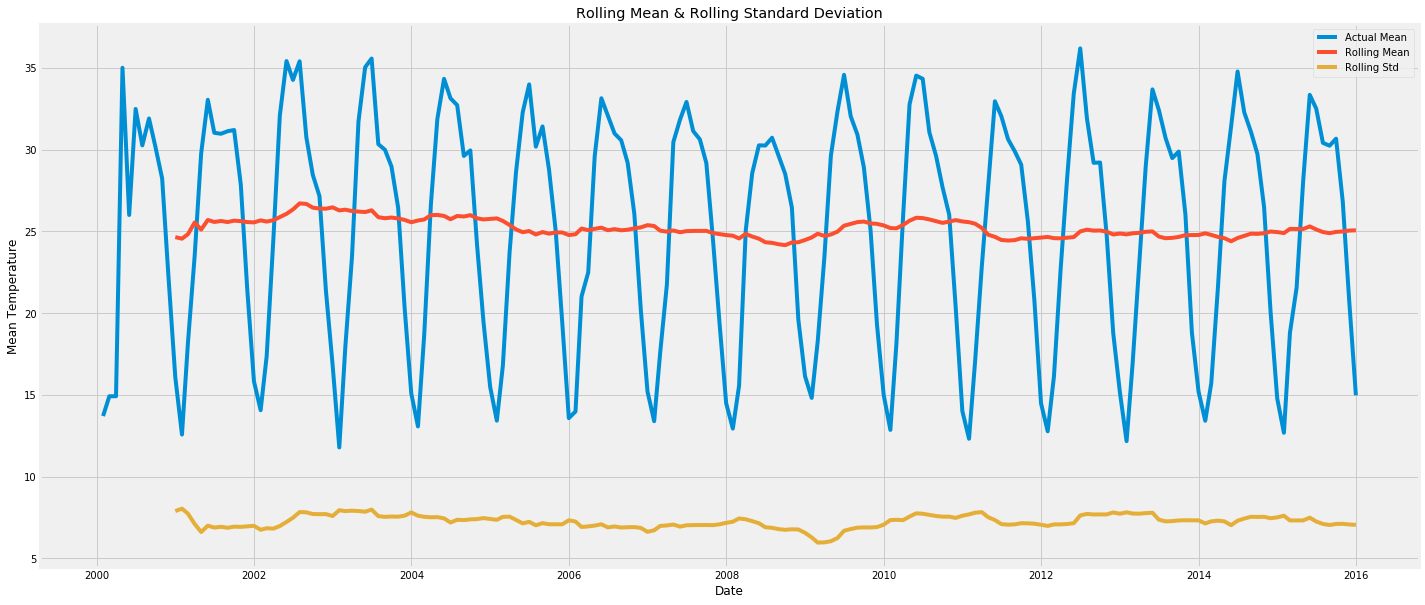

In [18]:
# check stationary: mean, variance(std)
plot_rolling_mean_std(train_df.temperature)

/home/shweta/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


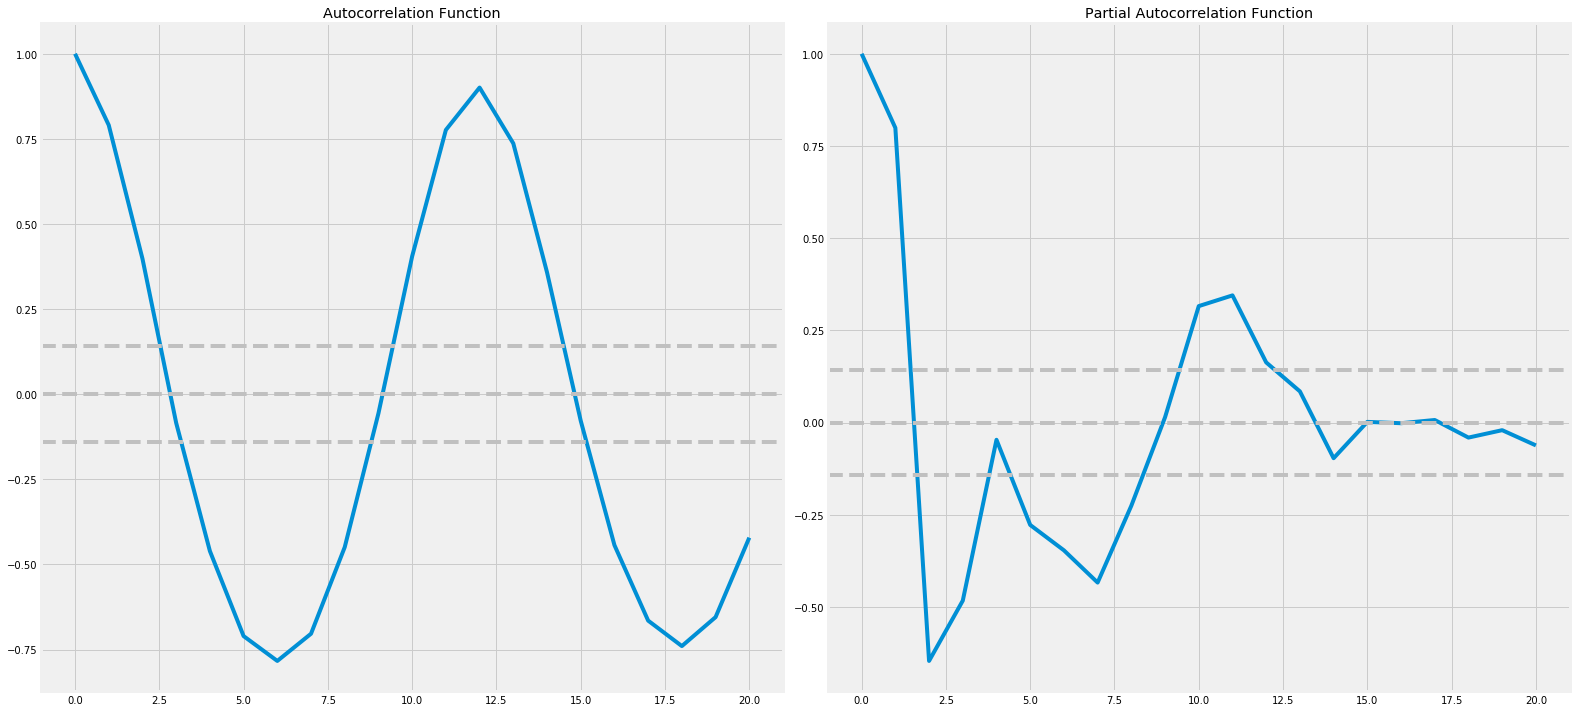

In [19]:
#Plot ACF and PACF
acf_lag = acf(train_df.values, nlags=20)
pacf_lag = pacf(train_df.values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(1,2,1)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [20]:
#ARIMA model
try:
    model = ARIMA(train_df.values, order=(2, 0, 2))
    model_fit = model.fit(disp=-1)
    print(model_fit.summary())
except:
    pass

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  192
Model:                     ARMA(2, 2)   Log Likelihood                -454.335
Method:                       css-mle   S.D. of innovations              2.551
Date:                Wed, 04 Nov 2020   AIC                            920.670
Time:                        18:33:20   BIC                            940.215
Sample:                             0   HQIC                           928.586
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1915      0.119    211.023      0.000      24.957      25.425
ar.L1.y        1.6785      0.024     69.840      0.000       1.631       1.726
ar.L2.y       -0.9519      0.023    -41.167      0.0

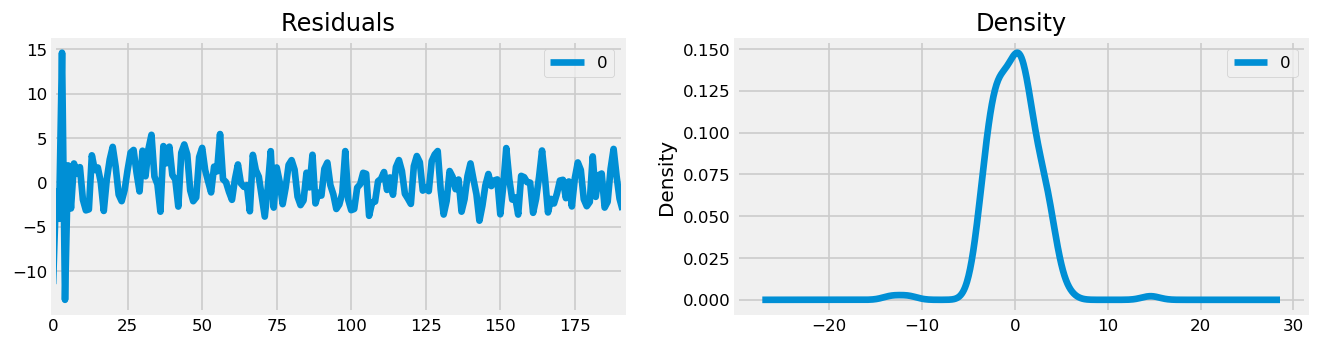

In [21]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

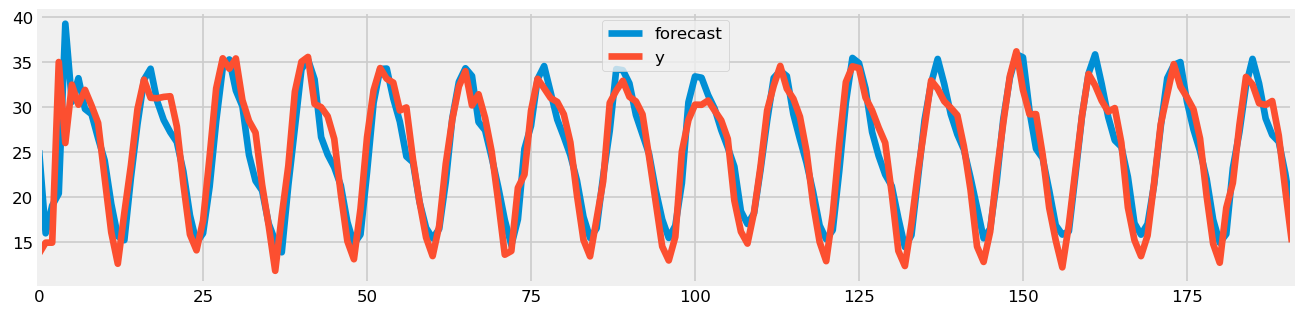

In [22]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

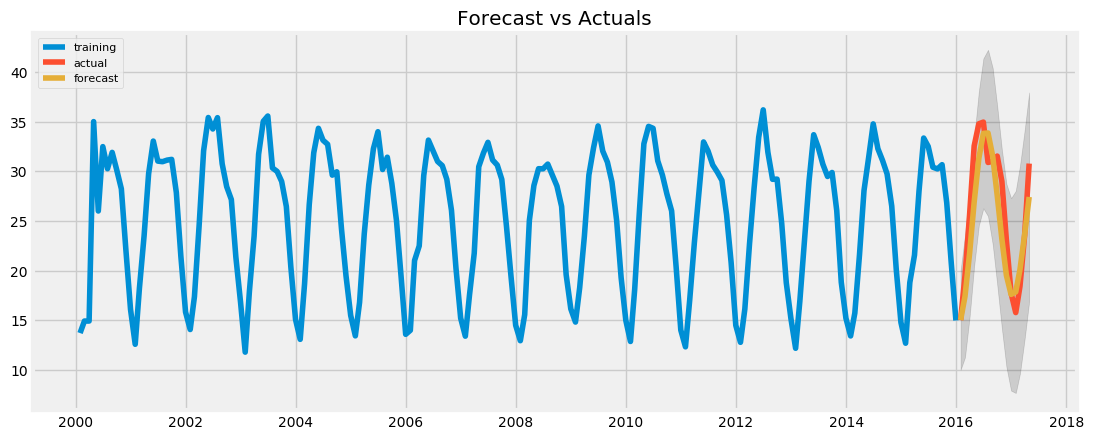

In [23]:
# # Forecast values for test_df
fc, se, conf = model_fit.forecast(16, alpha=0.05)  # 95% conf
#print(conf)
# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

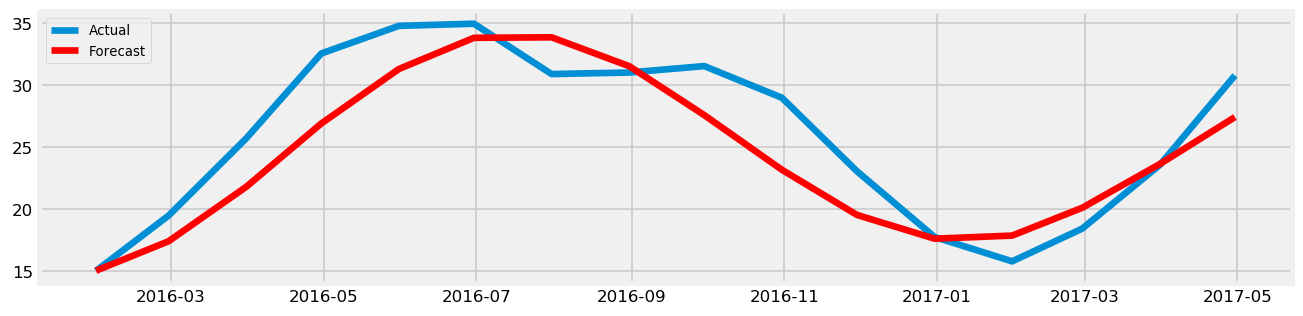

In [24]:
# plot Testing and Forecasted data
plt.plot(test_df, label='Actual')
plt.plot(fc_series, label='Forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
error = mean_squared_error(test_df, fc_series)
print('Test Mean Squared Error: ',error)

Test Mean Squared Error:  9.645860513873451
